In [28]:
import os, sys
from os.path import join

import nibabel as nib
import numpy as np
import pandas as pd

from nilearn.image import index_img
from nilearn.image import load_img
from nilearn.image import mean_img
from nilearn.image import new_img_like
from nilearn.masking import apply_mask

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Multivoxel approaches
This notebook explores whether we can build a multivoxel model for predicting the trial state (REST, MOTOR, IMAGERY) based on the first run of data, and then apply that model to subsequent runs. 


# Prep Inputs

In [29]:
# load timing files
trialOnsets = pd.read_csv('../data/subject001/timingFiles/trialOnsets.tsv', sep='\t')
trialOnsets

,onsets_TR1,onsets_TR2,trialTypes,weights,duration
0,4,2,rest,1.0,20
1,24,22,motor,1.0,10
2,34,32,rest,1.0,20
3,54,52,imagery,1.0,10
4,64,62,rest,1.0,20
5,84,82,imagery,1.0,10
6,94,92,rest,1.0,20
7,114,112,motor,1.0,10
8,124,122,rest,1.0,20
9,144,142,imagery,1.0,10


In [110]:
mask

'motorSphere_5mm_FUNC_mask.nii.gz'

In [122]:
# task labels
labels_1s = np.array(['nan'] * 186, dtype=object)
labels_1s_exclude2 = np.array(['nan'] * 186, dtype=object)
labels_2s = np.array(['nan'] * 93, dtype=object)

#loop over trialOnsets to populate labels arrays
for i,row in trialOnsets.iterrows():
    # 1s TRs
    startIdx = row['onsets_TR1']
    endIdx = startIdx + row['duration']+1
    labels_1s[startIdx:endIdx] = row['trialTypes']
    
    # 1s TRs, exclude 2s
    startIdx = row['onsets_TR1'] + 2
    endIdx = startIdx + row['duration'] - 2
    labels_1s_exclude2[startIdx:endIdx] = row['trialTypes']
    
    # 2s TRs
    startIdx = row['onsets_TR2']/2
    endIdx = startIdx + row['duration']/2 + 1
    labels_2s[int(startIdx):int(endIdx)] = row['trialTypes']
    
# convert to pandas series
labels_1s = pd.Series(labels_1s)
labels_1s_exclude2 = pd.Series(labels_1s_exclude2)
labels_2s = pd.Series(labels_2s)

In [123]:
labels_1s_exclude2

0        nan
1        nan
2        nan
3        nan
4        nan
5        nan
6       rest
7       rest
8       rest
9       rest
10      rest
11      rest
12      rest
13      rest
14      rest
15      rest
16      rest
17      rest
18      rest
19      rest
20      rest
21      rest
22      rest
23      rest
24       nan
25       nan
26     motor
27     motor
28     motor
29     motor
       ...  
156     rest
157     rest
158     rest
159     rest
160     rest
161     rest
162     rest
163     rest
164     rest
165     rest
166     rest
167     rest
168     rest
169     rest
170     rest
171     rest
172     rest
173     rest
174      nan
175      nan
176    motor
177    motor
178    motor
179    motor
180    motor
181    motor
182    motor
183    motor
184      nan
185      nan
dtype: object

We now have two arrays representing timept labels for each TR type (i.e. 1s vs 2s):
* **labels_1s**: timept labels for each volume in the 1s TR runs
* **labels_2s**: timept labels for each volume in the 2s TR runs

In [76]:
# check how many voxels are in the masks for each run (given that there was different coverage areas afterall)
for run in ['002', '003', '004', '005']:
    mask_img = load_img(join('../data/subject001/pyneal_{}/mask_transforms/FUNC_masks'.format(run), mask))

    print('run_{} - {} voxels'.format(run, int(sum(mask_img.get_data()))))

run_002 - 63 voxels
run_003 - 68 voxels
run_004 - 63 voxels
run_005 - 58 voxels


# First run model, Motor vs Rest

Try to train a classifier to accurately predict REST from MOTOR timepts based on the first run ONLY

**Goal:** Find the mask and model parameters that yield the maximum classification accuracy between MOTOR and REST timepts

Using an SVM binary classifier, we'll train/test the model using Kfold cross validation with features obtained from the following masks:
* functionally defined (5mm sphere around peak for MOTOR>REST contrast)
* anatomically defined (full L primary motor cortex)
* anatomically defined (L primary motor cortext thresholded at >50% prob)
* whole brain

For each mask, we'll compute classification accuracy for:
* all MOTOR and REST volumes
* exclude 2s of "transition" volumes between each trial

In [113]:
# import necessary libraries
from nilearn.input_data import NiftiMasker
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

from nilearn import plotting
from nilearn.plotting import plot_stat_map, show

In [117]:
# build a function to compute mean cross validation score for a given mask and condition label vector
def runClassification(mask, labels):
    """
    inputs:
        - mask: path to the mask file 
        - labels: a 1xNumTimepts array of timept labels 
    """
    
    # set up masker based on the mask
    masker = NiftiMasker(mask_img=mask, standardize=True)
    
    # load fMRI corresponding to voxels within mask
    fmri = masker.fit_transform('../data/subject001/pyneal_002/receivedFunc.nii.gz')
    
    # create an array mask for the conditions of interest
    conditions_mask = labels.isin(['rest', 'motor'])
    
    # grab only the fMRI data timepts that we're interested in
    fmri = fmri[conditions_mask]
    
    # mask the labels vector to match
    labels = labels[conditions_mask]
    
    # build the SVM decoder
    svc = SVC(kernel='linear', C=100)
    
    # set up cross-validator
    cv = KFold(n=len(fmri), n_folds=5)
    
    # run cross-validation
    cv_score = cross_val_score(svc, fmri, labels, cv=cv)
    
    print('{} - mean accuracy: {}, stdDev: {}'.format(os.path.split(mask)[-1], np.mean(cv_score), np.std(cv_score)))

In [124]:
masks = ['motorSphere_5mm_FUNC_mask.nii.gz',
         'motorCortex_FUNC_mask.nii.gz',
         'motorCortex_50prob_FUNC_mask.nii.gz',
         'wholeBrain_FUNC_mask.nii.gz']

for mask in masks:
    for labels in [labels_1s, labels_1s_exclude2]:
        maskFile = join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', mask)
        runClassification(maskFile, labels)

motorSphere_5mm_FUNC_mask.nii.gz - mean accuracy: 0.8617204301075269, stdDev: 0.0828546082846429
motorSphere_5mm_FUNC_mask.nii.gz - mean accuracy: 0.9623931623931623, stdDev: 0.03377720874137647
motorCortex_FUNC_mask.nii.gz - mean accuracy: 0.8886021505376345, stdDev: 0.09890041776952564
motorCortex_FUNC_mask.nii.gz - mean accuracy: 0.9250712250712251, stdDev: 0.07756197690153664
motorCortex_50prob_FUNC_mask.nii.gz - mean accuracy: 0.8352688172043011, stdDev: 0.07563780523801085
motorCortex_50prob_FUNC_mask.nii.gz - mean accuracy: 0.8943019943019943, stdDev: 0.07205443064320721
wholeBrain_FUNC_mask.nii.gz - mean accuracy: 0.8754838709677418, stdDev: 0.11439041006629316
wholeBrain_FUNC_mask.nii.gz - mean accuracy: 0.9096866096866096, stdDev: 0.07642340615693713


In [125]:
svc.decision_function

<bound method BaseSVC.decision_function of SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>

## 5mm motorSphere mask
try to train the classifier using voxels within the motor sphere mask only

In [77]:
from nilearn.input_data import NiftiMasker

In [86]:
# set up a masker based on the mask
masker = NiftiMasker(mask_img=join('../data/subject001/pyneal_002/mask_transforms/FUNC_masks', mask), 
                     standardize=True)

fmri = masker.fit_transform('../data/subject001/pyneal_002/receivedFunc.nii.gz')
fmri.shape

(186, 63)

In [87]:
conditions_mask = labels_1s.isin(['rest', 'motor'])

In [88]:
# apply the conditions mask to the fMRI data to isolate the timepts we're interested in
fmri = fmri[conditions_mask]
fmri.shape

(151, 63)

In [95]:
# mask the conditions in the same way
conditions = labels_1s[conditions_mask]
conditions.shape

(151,)

### SVM Decoder
We now have a 2D dataset of features and samples. The features are the voxels in the mask, and the samples are the timepoints that we isolated that pertain to a specific trial type. In addition, we have a conditions vector that provides a label for each of the samples. This is all we need to start using scikit-learn

In [90]:
# create the decoder
from sklearn.svm import SVC

In [93]:
svc = SVC(kernel='linear', C=100)
print(svc)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [94]:
# train/test with cross-validation:
from sklearn.cross_validation import KFold

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [99]:
from sklearn.cross_validation import cross_val_score

In [100]:
# OR, do cross validation even easier:
cv_score = cross_val_score(svc, fmri, conditions, cv=cv)
print(cv_score)

[ 0.74193548  0.93333333  0.96666667  0.8         0.86666667]


In [101]:
mean(cv_score)

0.86172043010752686

### Which voxels have the most weight?

In [102]:
coef_ = svc.coef_
coef_.shape

(1, 63)

In [103]:
# these are the weights, but we need to know WHERE in the brain these voxels were
# so, invert the mask
coef_img = masker.inverse_transform(coef_)

In [107]:
# visualize
from nilearn import plotting
from nilearn.plotting import plot_stat_map, show

In [106]:
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (80, 80, 15, 1)
affine: 
[[   3.     0.     0.  -118.5]
 [   0.     3.     0.  -118.5]
 [   0.     0.     4.   -28. ]
 [   0.     0.     0.     1. ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 80 80 15  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [ 1.  3.  3.  4.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform

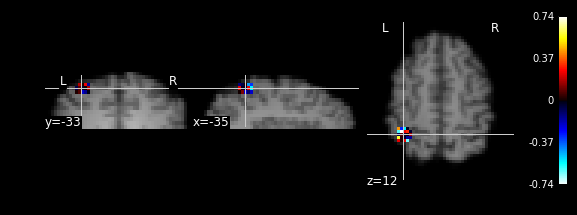

In [109]:
plot_stat_map(coef_img, bg_img='../data/subject001/pyneal_002/mask_transforms/hires_FUNC.nii.gz')